In [1]:
import numpy as np
import pandas as pd
from mlflow.tracking.client import MlflowClient
from matplotlib import pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

sns.set_style("ticks", {'axes.grid': True})
%matplotlib inline

In [2]:
load_dotenv()

client = MlflowClient()

def load_metric(run_id, metric_name, fill_missing=0) -> pd.Series:
    chart = client.get_metric_history(run_id, metric_name)
    steps = [metric.step for metric in chart]
    values = [metric.value for metric in chart]
    return (
        pd.Series(data=values, index=steps, name=metric_name)
        .reindex(range(max(steps) + 1), fill_value=fill_missing)
        .sort_index()
    )
    # return np.array([v.value for v in sorted(metric, key=lambda x: x.step)])

# 1. plane.mp4 (airplane)

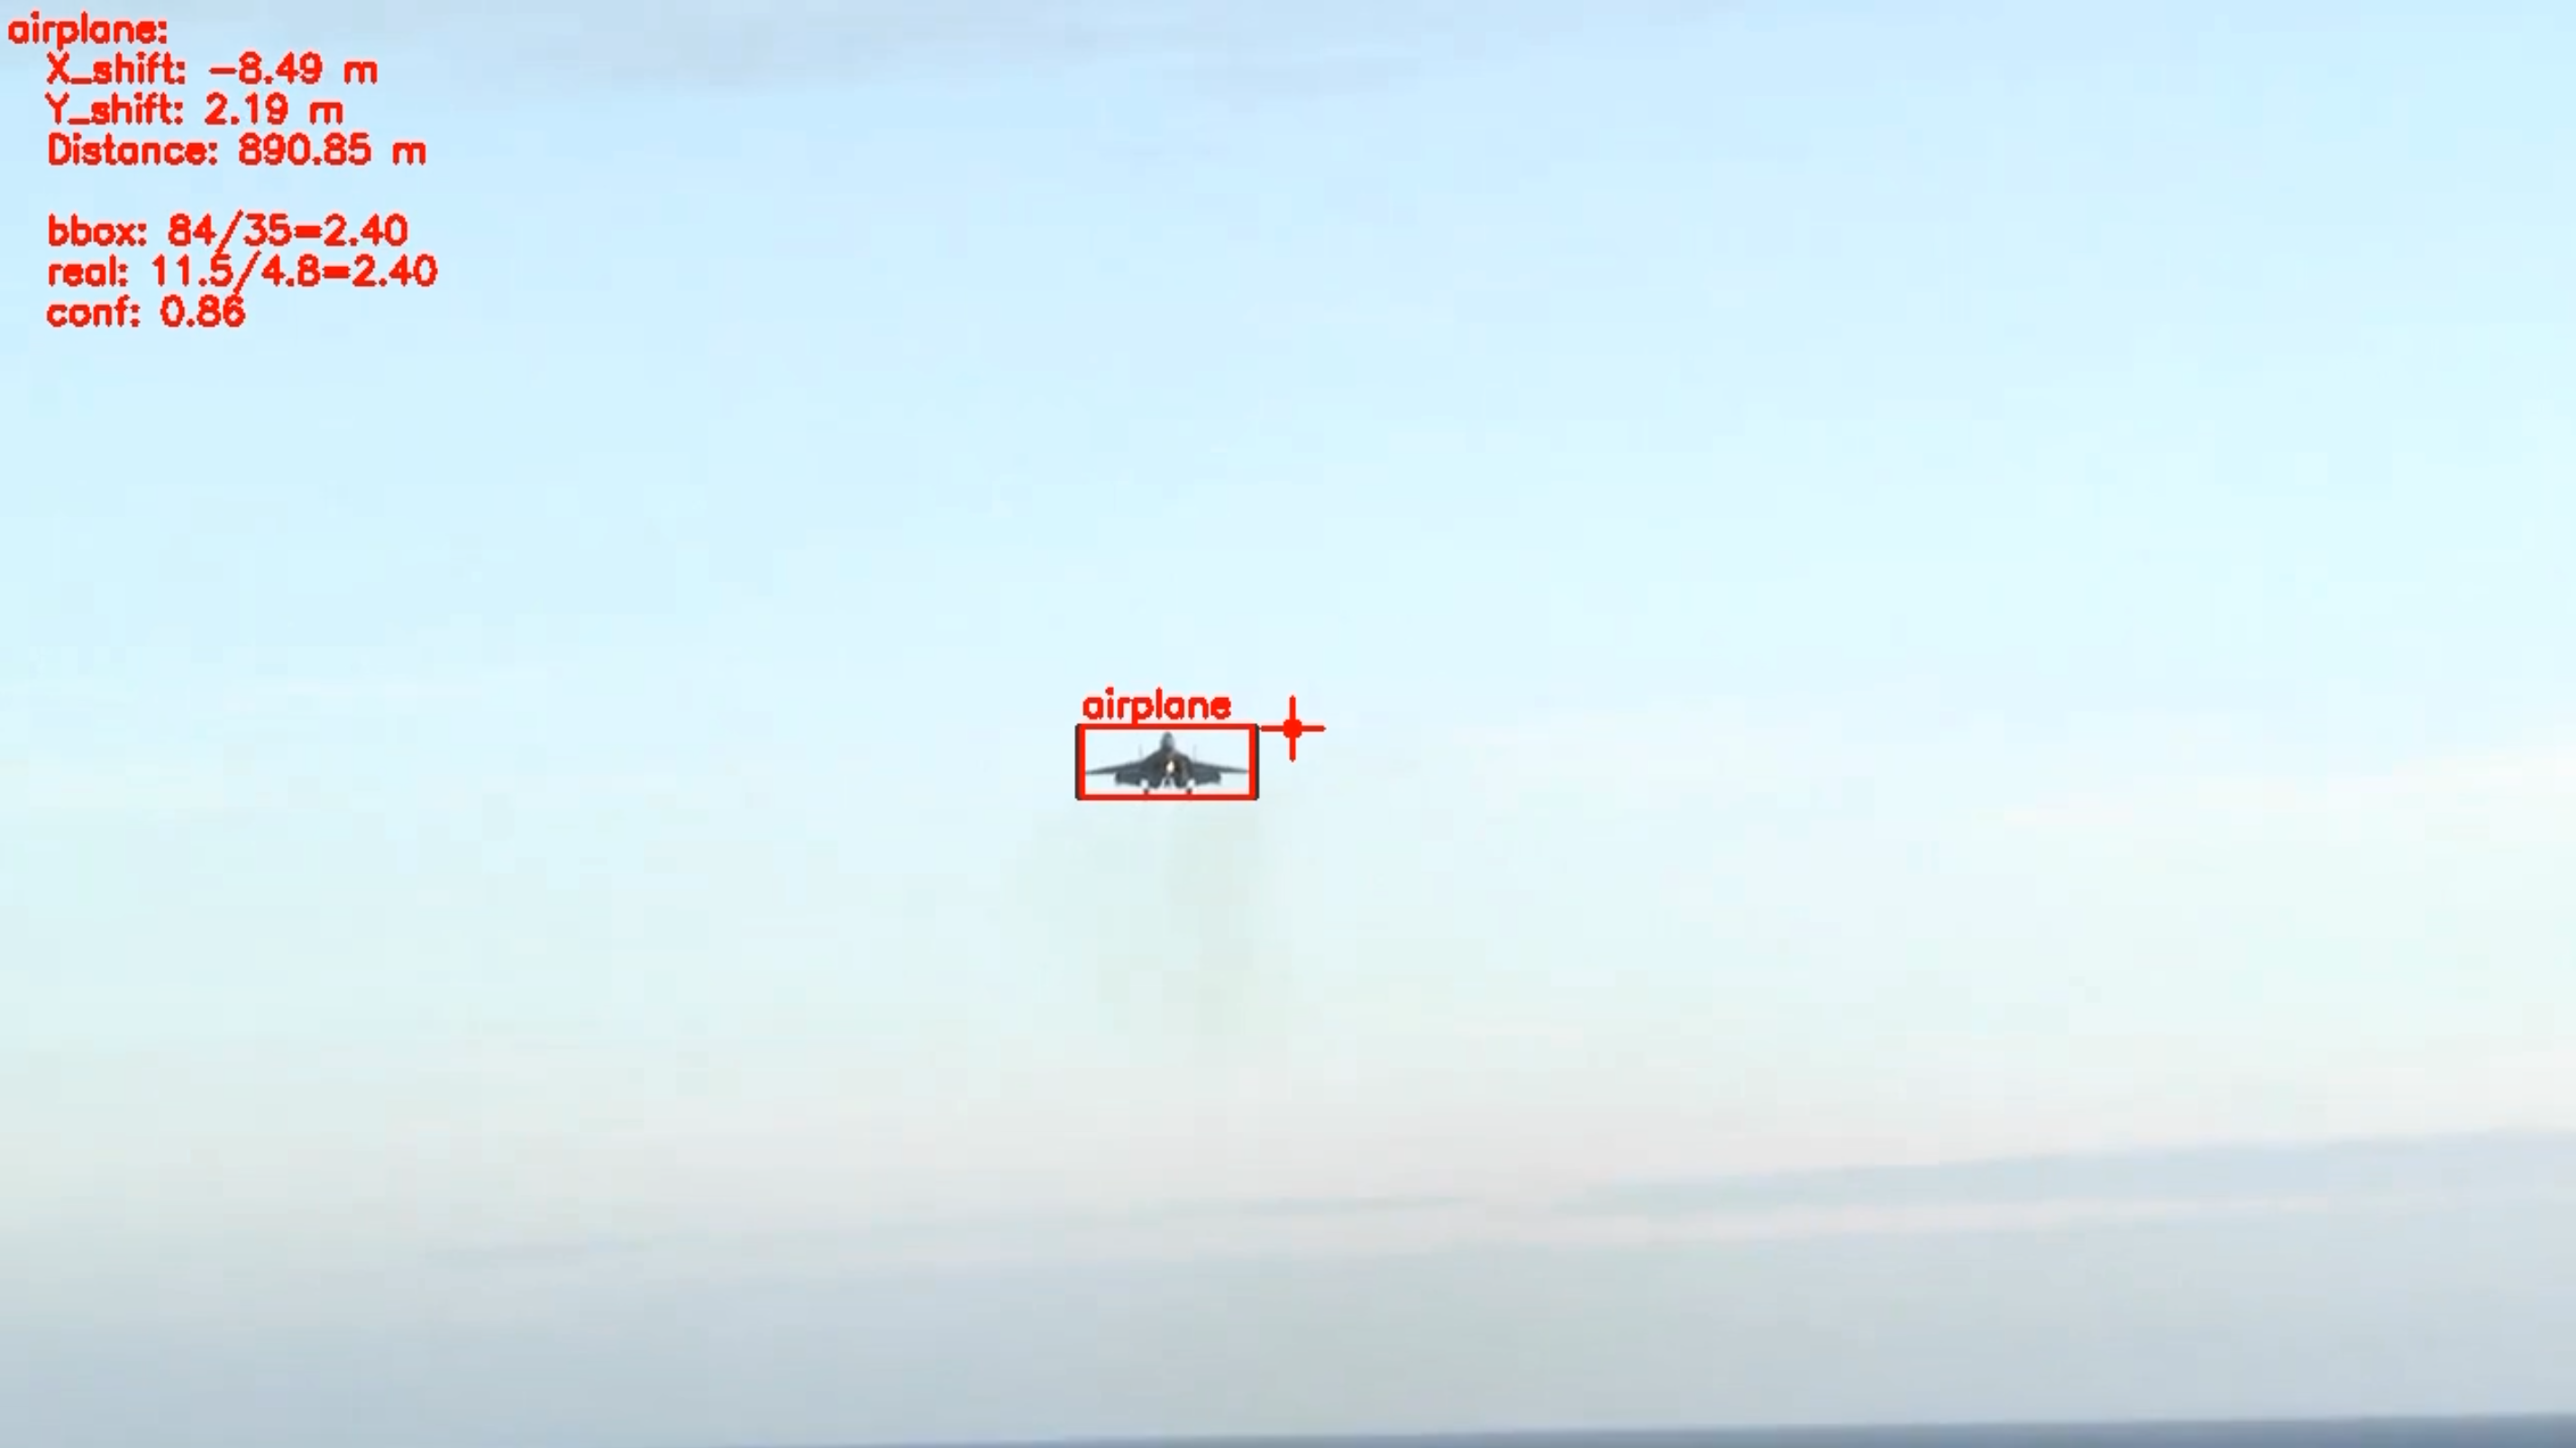

In [3]:
run_id1 = "d7a87042ac39426c9350f19688ee7ecd"
run_params1 = client.get_run(run_id1).data.params
run_params1

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'plane.mp4',
 'oname': 'airplane',
 'owidth': '11.5',
 'oheight': '4.8',
 'cfocal': '25.0',
 'cwidth': '4.92',
 'cheight': '2.77',
 'ratiodev': '0.4'}

### размеры пикселей камеры

In [4]:
px_size_x = load_metric(run_id1, "px_size_x", fill_missing=None)
px_size_y = load_metric(run_id1, "px_size_y", fill_missing=None)

print(px_size_x.apply(["min", "max", "mean"]), px_size_y.apply(["min", "max", "mean"]), sep="\n")

min     0.003844
max     0.003844
mean    0.003844
Name: px_size_x, dtype: float64
min     0.003847
max     0.003847
mean    0.003847
Name: px_size_y, dtype: float64


In [5]:
print(f'sensor ratio={float(run_params1["cwidth"]) / float(run_params1["cheight"])}')
print(f'frame ratio={1280 / 720}')

sensor ratio=1.7761732851985559
frame ratio=1.7777777777777777


Размеры пикселей отличаются в 6 знаке после запятой из-за особенностей формирования изображения: соотношения линейных размеров сенсора и размеров изображения не совпадают идеально

### смещение объекта от центра

<Axes: ylabel='center_shift_x'>

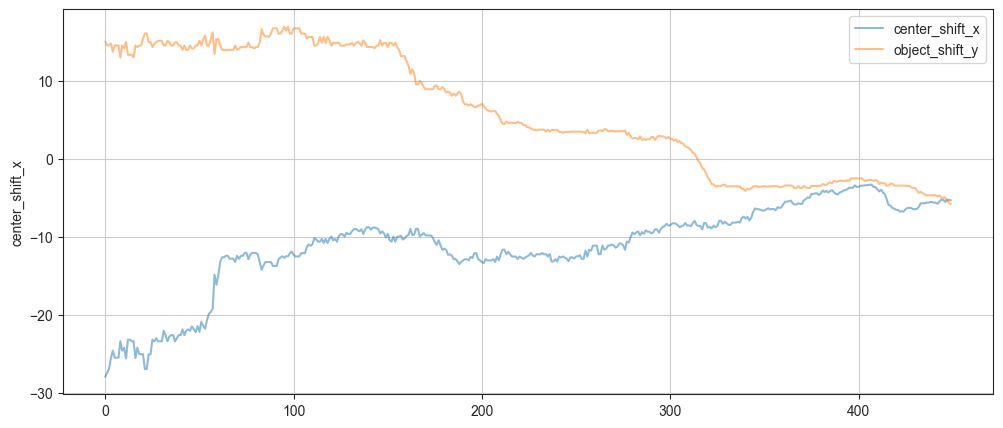

In [6]:
center_shift_x = load_metric(run_id1, "center_shift_x", fill_missing=None)
center_shift_y = load_metric(run_id1, "center_shift_y", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(center_shift_x, alpha=0.5, label="center_shift_x")
sns.lineplot(center_shift_y, alpha=0.5, label="object_shift_y")

* `center_shift_x` - смещение объекта по горизонтальной оси
* `center_shift_y` - смещение объекта по вертикальной оси

По видео видно, что камера периодически смещается. Резкие изменения на графиках показывают эти моменты

### расстояние до объекта

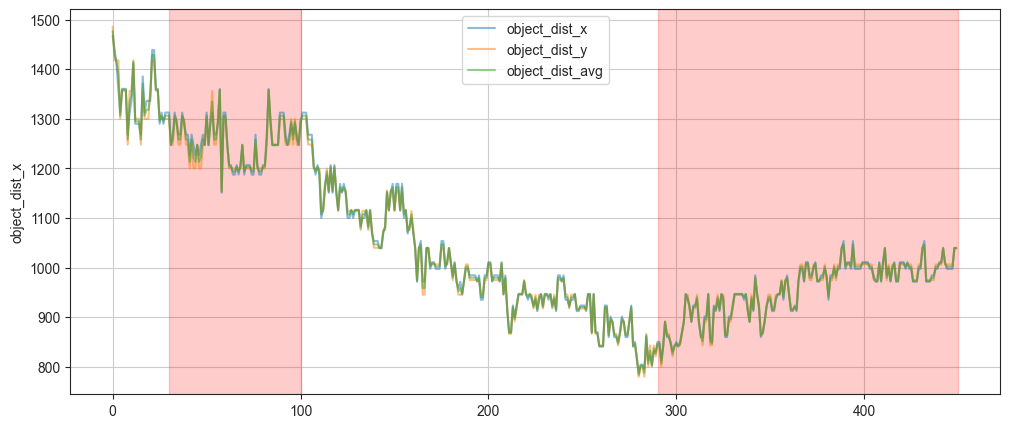

In [7]:
object_dist_x = load_metric(run_id1, "object_dist_x", fill_missing=None)
object_dist_y = load_metric(run_id1, "object_dist_y", fill_missing=None)
object_dist_avg = load_metric(run_id1, "object_dist_avg", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(object_dist_x, alpha=0.5, label="object_dist_x")
sns.lineplot(object_dist_y, alpha=0.5, label="object_dist_y")
sns.lineplot(object_dist_avg, alpha=0.5, label="object_dist_avg")
plt.axvspan(30, 100, alpha=0.2, color='red')
plt.axvspan(290, 450, alpha=0.2, color='red')

* `object_dist_x` - расстояние от наблюдателя до проекции центра объекта на горизонтальную ось
* `object_dist_y` - расстояние от наблюдателя до проекции центра объекта на вертикальную ось
* `object_dist_avg` - расстояние от наблюдателя до центра объекта

1. На графике видно, что все 3 расстояния находятся очень близко друг к другу
2. Также на графике есть области (помечены красным), где поведение графика меняется:
  * левая область - расстояние до объекта перестает уменьшаться
  * правая область - расстояние до объекта начинает увеличиваться.
3. Для правой области на видео заметно, что камера не просто меняет положение, а меняется фокусное расстояние, так что нельзя достоверно указать расстояние до объекта на этой области

### коэффициент подобия для расчета реальных размеров объекта

<Axes: ylabel='sim_koef_x'>

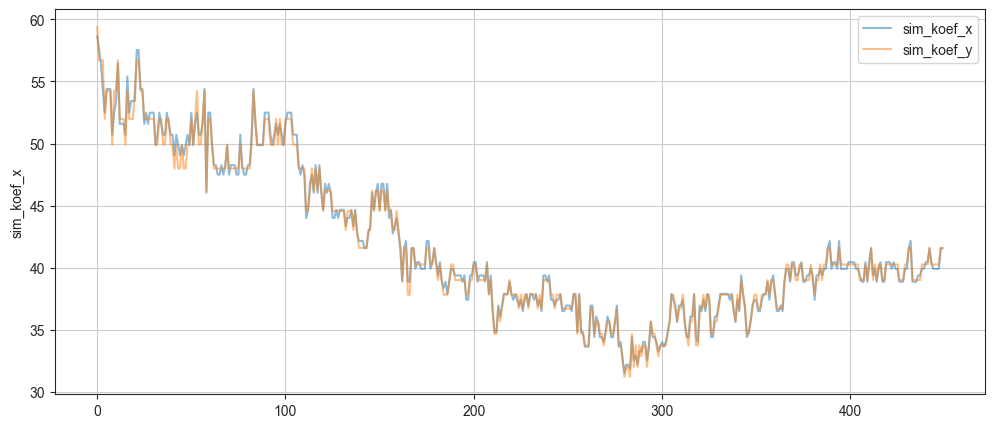

In [8]:
sim_koef_x = load_metric(run_id1, "sim_koef_x", fill_missing=None)
sim_koef_y = load_metric(run_id1, "sim_koef_y", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(sim_koef_x, alpha=0.5, label="sim_koef_x")
sns.lineplot(sim_koef_y, alpha=0.5, label="sim_koef_y")

In [9]:
print(sim_koef_x.corr(object_dist_x))
print(sim_koef_y.corr(object_dist_y))

0.9999999534167179
0.9999999905794713


Для самопроверки: коэффициент подобия меняется пропорционально изменению расстояния до объекта

### размеры рамки детектора

<Axes: ylabel='box_size_x'>

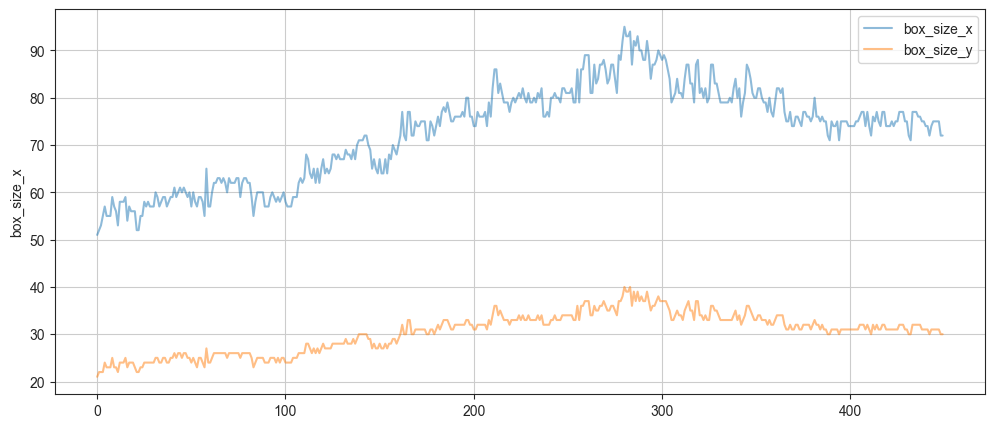

In [10]:
box_size_x = load_metric(run_id1, "box_size_x", fill_missing=None)
box_size_y = load_metric(run_id1, "box_size_y", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(box_size_x, alpha=0.5, label="box_size_x")
sns.lineplot(box_size_y, alpha=0.5, label="box_size_y")

У объекта горизонтальные размеры больше чем вертикальные

### уверенность детектора в предсказании объекта

<Axes: ylabel='object_conf'>

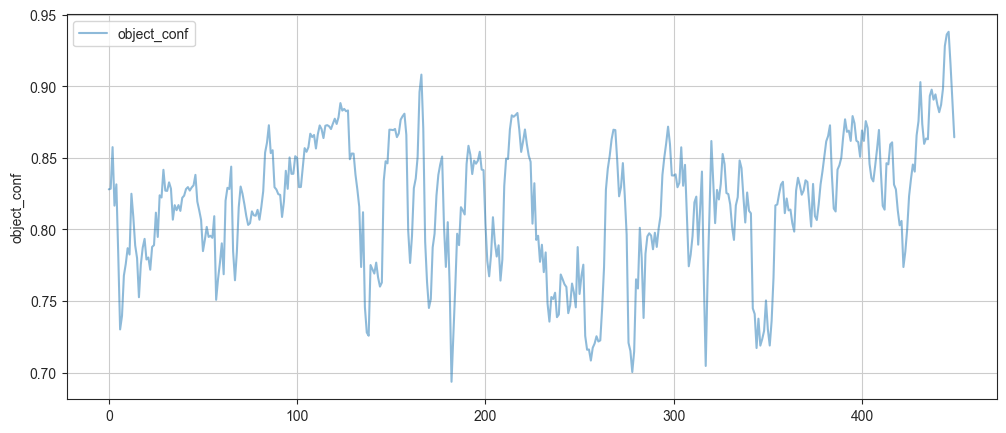

In [11]:
object_conf = load_metric(run_id1, "object_conf", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(object_conf, alpha=0.5, label="object_conf")

Уверенность детектора остается на высоком уровне на протяжении всего видео

# 2. fourway.avi (person)

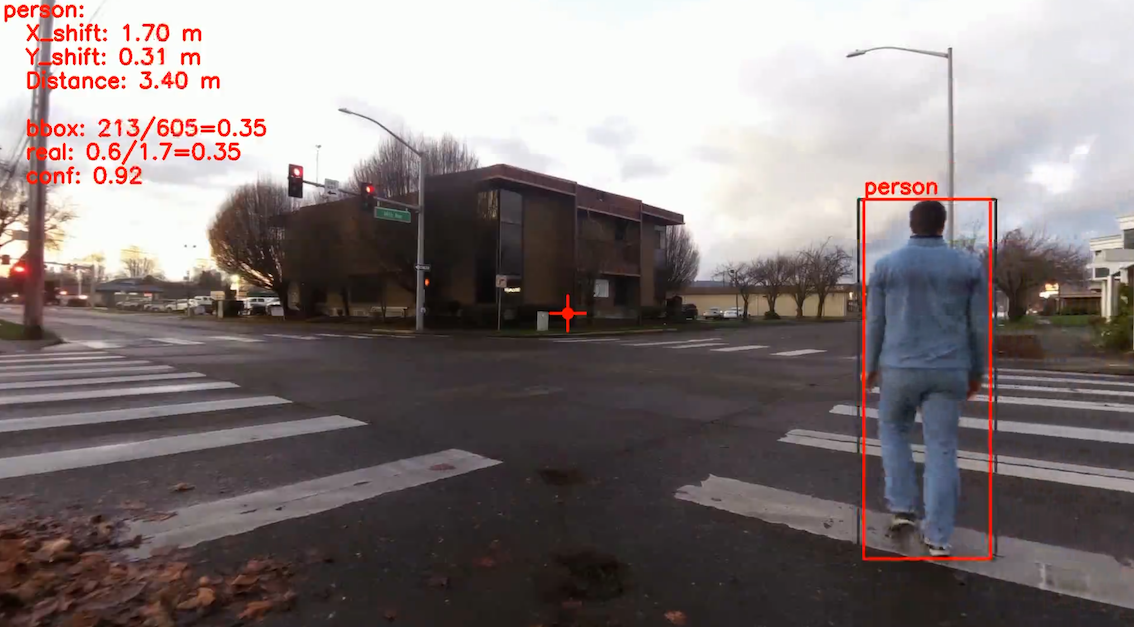

In [12]:
run_id2 = "00abcf0b2fab4c57989ab8ba39f3cde7"
run_params2 = client.get_run(run_id2).data.params
run_params2

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'fourway.avi',
 'oname': 'person',
 'owidth': '0.6',
 'oheight': '1.7',
 'cfocal': '4.0',
 'cwidth': '7.38',
 'cheight': '4.15',
 'ratiodev': '0.5'}

### размеры пикселей камеры

In [13]:
px_size_x = load_metric(run_id2, "px_size_x", fill_missing=None)
px_size_y = load_metric(run_id2, "px_size_y", fill_missing=None)

print(px_size_x.apply(["min", "max", "mean"]), px_size_y.apply(["min", "max", "mean"]), sep="\n")

min     0.003844
max     0.003844
mean    0.003844
Name: px_size_x, dtype: float64
min     0.003843
max     0.003843
mean    0.003843
Name: px_size_y, dtype: float64


In [14]:
print(f'sensor ratio={float(run_params2["cwidth"]) / float(run_params2["cheight"])}')
print(f'frame ratio={1920 / 1080}')

sensor ratio=1.778313253012048
frame ratio=1.7777777777777777


Размеры пикселей отличаются в 6 знаке после запятой из-за особенностей формирования изображения: соотношения линейных размеров сенсора и размеров изображения не совпадают идеально

### смещение объекта от центра

<Axes: ylabel='center_shift_x'>

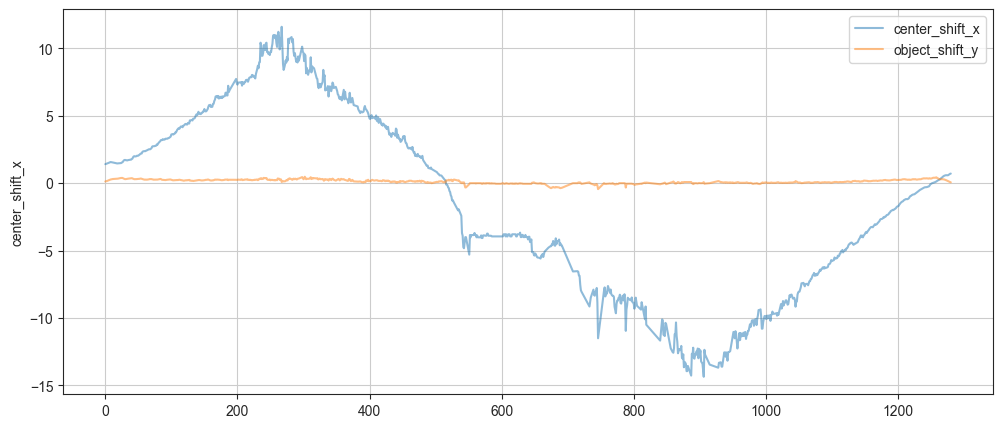

In [15]:
center_shift_x = load_metric(run_id2, "center_shift_x", fill_missing=None)
center_shift_y = load_metric(run_id2, "center_shift_y", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(center_shift_x, alpha=0.5, label="center_shift_x")
sns.lineplot(center_shift_y, alpha=0.5, label="object_shift_y")

* `center_shift_x` - смещение объекта по горизонтальной оси
* `center_shift_y` - смещение объекта по вертикальной оси

Из-за расположения камеры объект смещается практически только по горизонтальной оси

### расстояние до объекта

<Axes: ylabel='object_dist_x'>

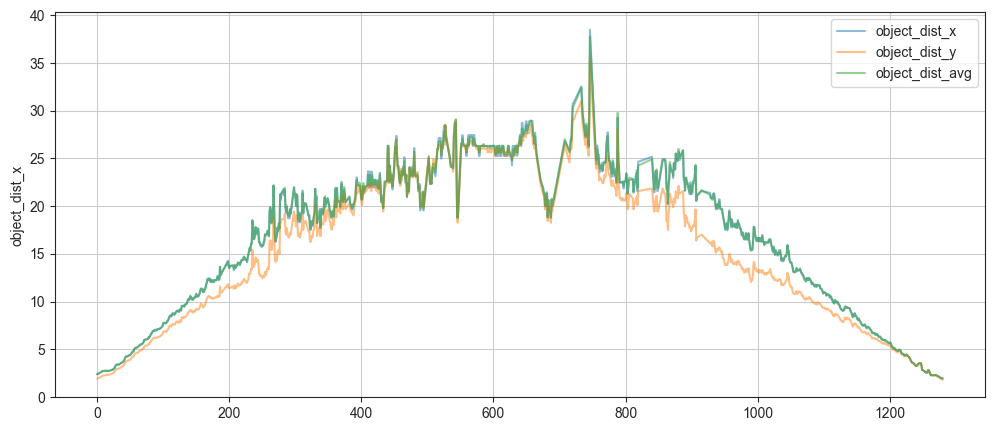

In [16]:
object_dist_x = load_metric(run_id2, "object_dist_x", fill_missing=None)
object_dist_y = load_metric(run_id2, "object_dist_y", fill_missing=None)
object_dist_avg = load_metric(run_id2, "object_dist_avg", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(object_dist_x, alpha=0.5, label="object_dist_x")
sns.lineplot(object_dist_y, alpha=0.5, label="object_dist_y")
sns.lineplot(object_dist_avg, alpha=0.5, label="object_dist_avg")

<Axes: ylabel='center_dist_y'>

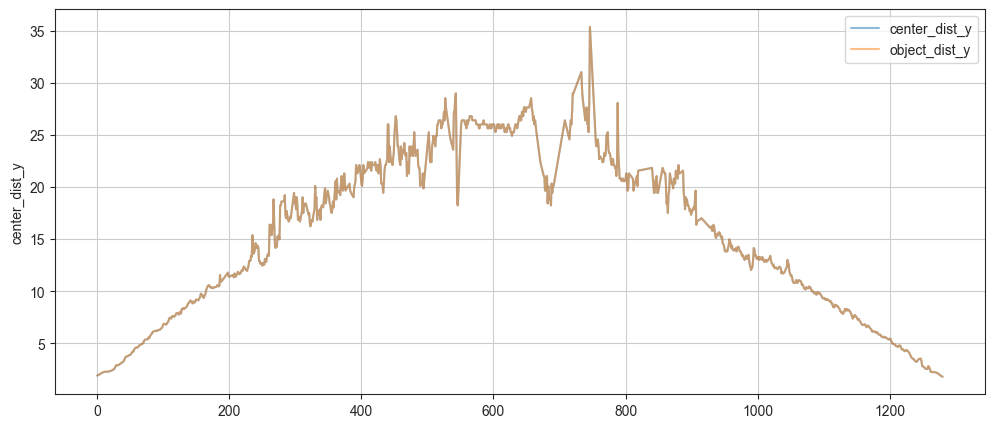

In [17]:
center_dist_y = load_metric(run_id2, "center_dist_y", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(center_dist_y, alpha=0.5, label="center_dist_y")
sns.lineplot(object_dist_y, alpha=0.5, label="object_dist_y")

* `object_dist_x` - расстояние от наблюдателя до проекции центра объекта на горизонтальную ось
* `object_dist_y` - расстояние от наблюдателя до проекции центра объекта на вертикальную ось
* `object_dist_avg` - расстояние от наблюдателя до центра объекта
* `center_dist_y` - расстояние от наблюдателя до центра кадра (по вертикальным размерам пикселей)

Видно, что проекция на вертикальную ось (`object_dist_y`) в некоторых местах сильно отклоняется от расстояния до объекта. Это происходит из-за того, что объект практически не смещается по вертикали, а только по горизонтали. И расстояние `object_dist_y` практически равно расстоянию `center_dist_y`

### коэффициент подобия для расчета реальных размеров объекта

<Axes: ylabel='sim_koef_x'>

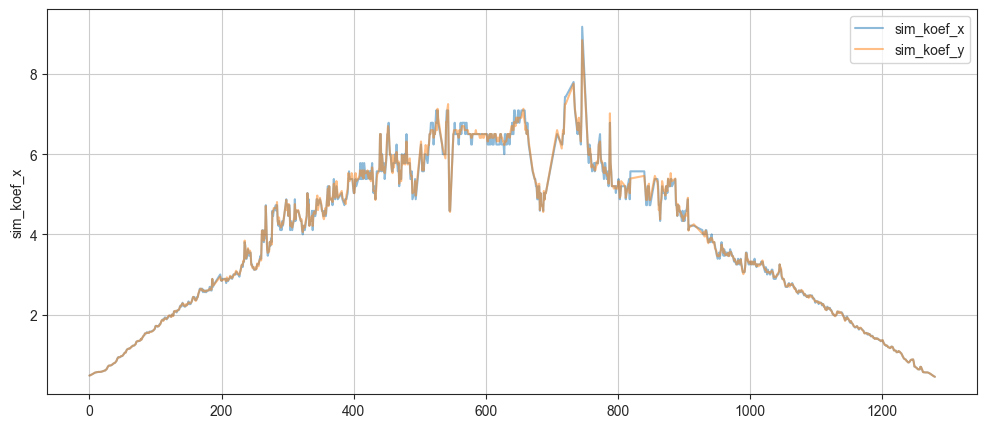

In [18]:
sim_koef_x = load_metric(run_id2, "sim_koef_x", fill_missing=None)
sim_koef_y = load_metric(run_id2, "sim_koef_y", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(sim_koef_x, alpha=0.5, label="sim_koef_x")
sns.lineplot(sim_koef_y, alpha=0.5, label="sim_koef_y")

In [19]:
print(sim_koef_x.corr(object_dist_x))
print(sim_koef_y.corr(object_dist_y))

0.9871425638705537
0.9999998387456113


Для самопроверки: коэффициент подобия меняется пропорционально изменению расстояния до объекта

### размеры рамки детектора

<Axes: ylabel='box_size_x'>

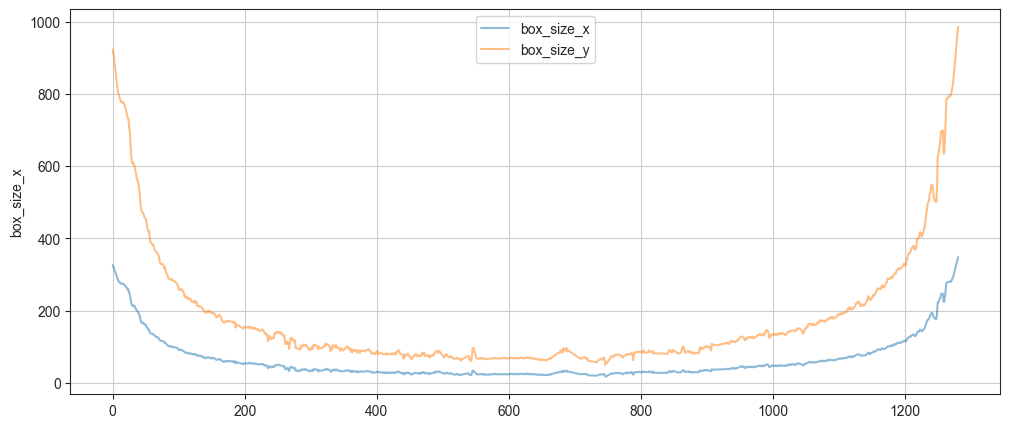

In [20]:
box_size_x = load_metric(run_id2, "box_size_x", fill_missing=None)
box_size_y = load_metric(run_id2, "box_size_y", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(box_size_x, alpha=0.5, label="box_size_x")
sns.lineplot(box_size_y, alpha=0.5, label="box_size_y")

1. Объект имеет вертикальные размеры больше чем горизонтальные, так что метрика `box_size_x` имеет больший диапазон значений чем `box_size_x`
2. Из-за особенностей расположения камеры (на углу перекрестка) объект отдаляется быстрее на первой зебре и приближается быстрее на последней зебре

### уверенность детектора в предсказании объекта

<Axes: ylabel='object_conf'>

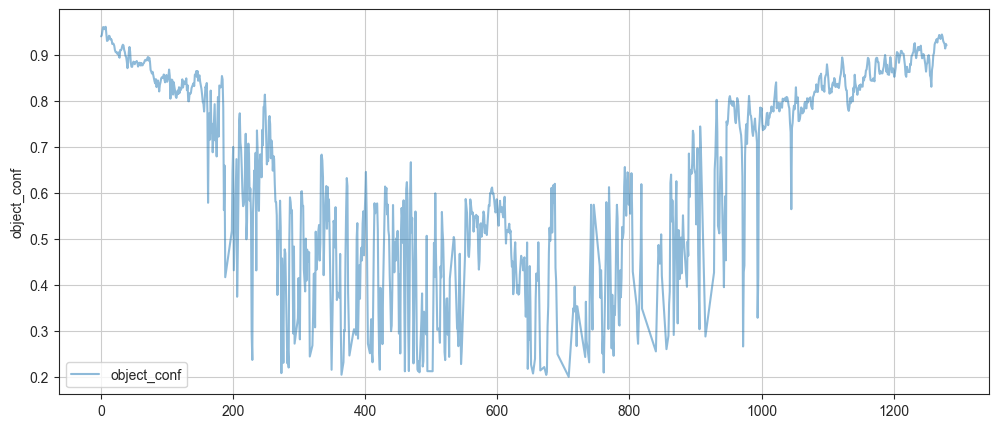

In [21]:
object_conf = load_metric(run_id2, "object_conf", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(object_conf, alpha=0.5, label="object_conf")

<Axes: ylabel='object_conf'>

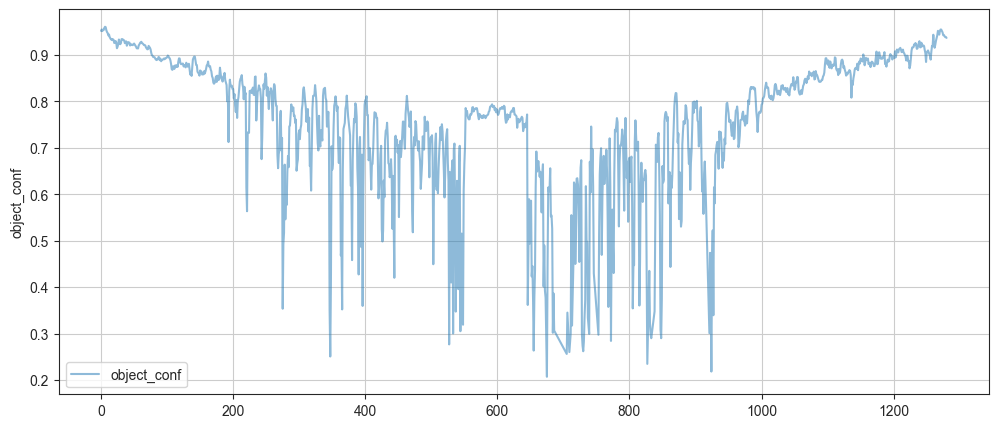

In [22]:
object_conf = load_metric("33f15bbf015a461baafb18fa138377c8", "object_conf", fill_missing=None)

plt.figure(figsize=(12, 5))
sns.lineplot(object_conf, alpha=0.5, label="object_conf")

Видно, что детектору намного сложнее определять объект на большом расстоянии.

Также на первом графике работа детектора `yolov8n`, а на втором - более сложная модель `yolov8m`. Видно, что более сложная модель более уверена в своих предсказаниях